# Laboratorium 3

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.added_points.append(PointsCollection())
         
    def add_line(self, event):
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.added_lines.append(LinesCollection())

    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

class LinesCollection:
    def __init__(self, lines = [], **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)
    
class Plot:
    def __init__(self, scenes = [Scene()], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(callback.add_line)
        return [b_prev, b_next, b_add_point, b_add_line]
    
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes
        
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
  
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(self.callback)
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        


### Przykłady użycia

##### Proste rysowanie

Należy utworzyć zmienną z obiuektem `Plot`, który przyjmuje jako parametr konstruktora listę scen lub string ze scenami w formacie json. Następnie po dodaniu wszystkich, na samym końcu programu, należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


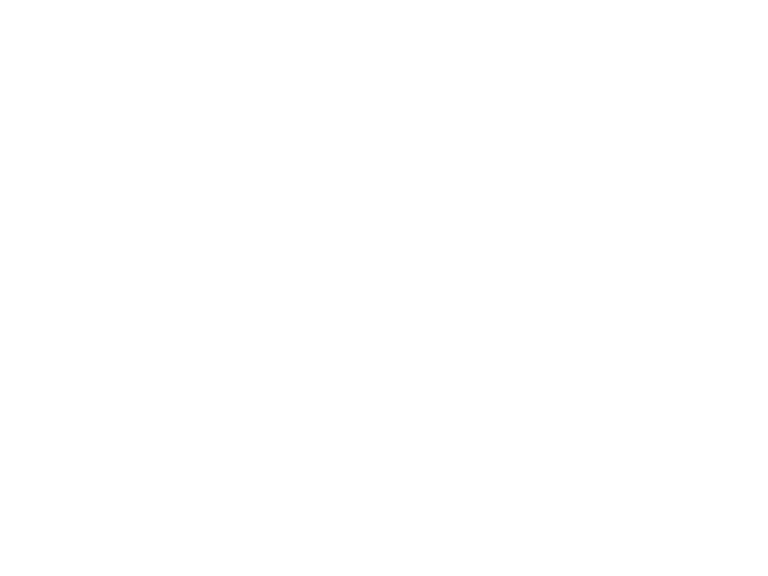

In [3]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red', s=1), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot = Plot(scenes)
plot.add_scene(Scene([PointsCollection([(2, 1)])], [LinesCollection([[(1,2),(2,3)]])]))
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


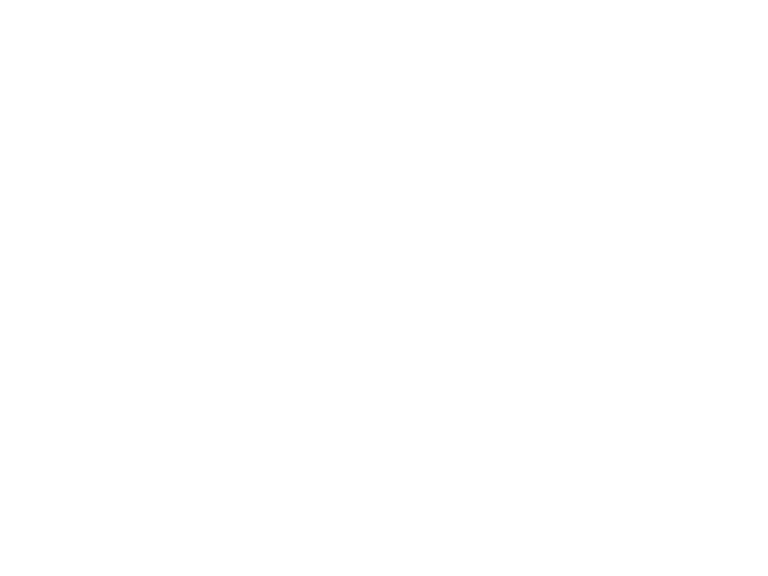

In [4]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.txt: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

In [5]:
X = 0


##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

In [6]:

class Point:
    def __init__(self, coord, isLeft=False, isInter=False): ## coord : tuple(x, y), isLeft: boolean value if point
                                            ## is the beginning or the end of the line 
        self.isLeft = isLeft
        self.coord = coord
        self.isInter = isInter
        self.line = None
        self.key = coord[1]
        
    def add_other(self, other):
        self.other = other
    
    def calc_line(self):
        pa, pb = self.coord, self.other.coord
        a1 = (pb[1] - pa[1])/ (pb[0] - pa[0])
        b1 = pa[1] - a1*pa[0]
        return a1, b1
    
    def get_line(self):
        if self.isInter:
            raise Exception("this is intersection point, no line to be returned")
        if not self.isLeft:
            return self.other.get_line()
        if self.line is None:
            self.line = self.calc_line()
        return self.line
    
    def as_line(self):  # get line in form of [(x,y), (x,y)]
        if self.isInter:
            raise Exception("this is intersection point, no line to be returned")
        if not self.isLeft:
            return self.other.as_line()
        return [self.coord, self.other.coord]
        
    def add_inters_points(self, point1, point2):  # 1st points of lines that intersect 
        self.collidingLine1 = point1
        self.collidingLine2 = point2
        
    def __lt__(self, other):
        global X
        lineA = self.get_line()
        lineB = other.get_line()
        return lineA[0]*X + lineA[1] < lineB[0]*X + lineB[1]
        
    def __eq__(self, other): 
        return self.coord == other.coord
    def __str__(self):
        return str(self.coord)
    def __repr__(self):
        return str(self.coord)
    def __hash__(self):
        return hash(self.coord)

In [7]:
""" helper function to change [(x,y), (x,y)] into Point a, Point b"""
def line_factory(line):
    p1 = Point( line[0], isLeft=True)
    p2 = Point( line[1])    
    p1.add_other(p2)
    p2.add_other(p1)
    return p1, p2

In [8]:
"""  returns points of intersection or None if lines don't intersect """
def intersect( startPt1, startPt2): 
    a1, b1 = startPt1.get_line()
    a2, b2 = startPt2.get_line()
    W = a2 - a1
    if W == 0:
        return None  # parralel 
    W1 = b1 - b2
    W2 = b1*a2 - a1*b2
    x, y = W1/W, W2/W  
    # check if x not outside segments 
    if x < min(startPt1.other.coord[0], startPt2.other.coord[0]) and \
        x >max(startPt1.coord[0], startPt2.coord[0]):
        interPt = Point( (x, y), isLeft=False, isInter=True )
        interPt.add_inters_points(startPt1, startPt2)
        return interPt
    return None 

In [9]:
def pointsToLineCoord(points):
    if len(points) == 1:
        return [points[0].coord, points[0].other.coord]
    ordinLines = []
    for point in points:
        if point.isLeft:
            line = [point.coord, point.other.coord]
        ordinLines.append(line)
    return ordinLines

<IPython.core.display.Javascript object>


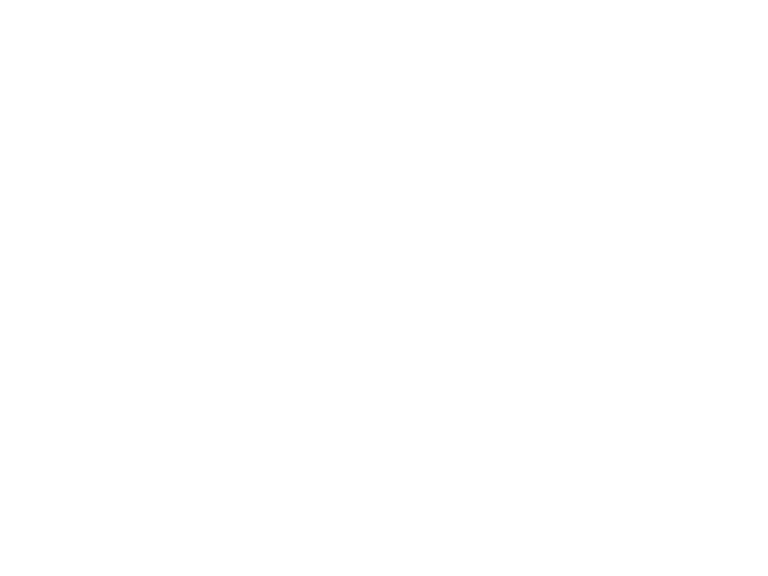

In [10]:
""" Add points and/or lines here """
plot1 = Plot()
plot1.draw()

[]


<IPython.core.display.Javascript object>


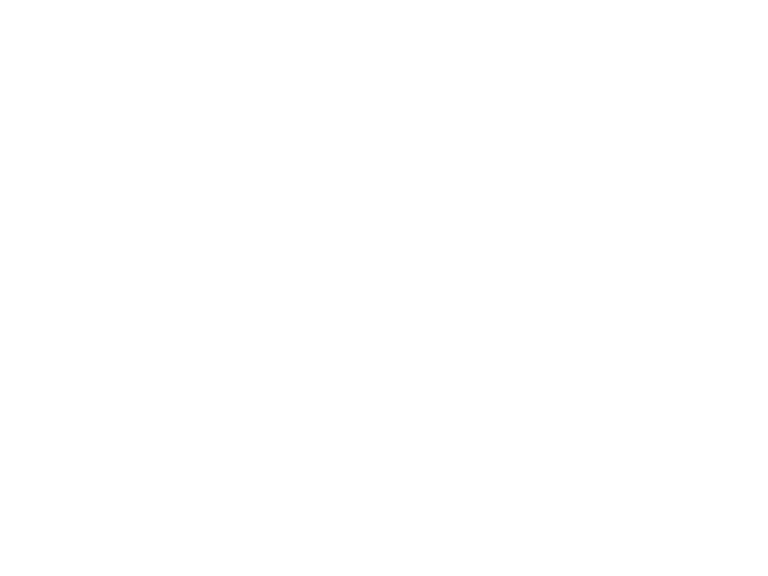

In [11]:
""" execute to add last added lines """
myLines = []  # list of added points
plot2 = Plot([plot1.get_added_elements()])
linCols = plot1.get_added_lines()  # list of collections of lines 
ptsCols = plot1.get_added_points()  # list of collections of points
for linCol in linCols:
    for line in linCol.lines:
        if line[0][0] == line[1][0]:
            continue;
        if line[0][0] > line[1][0]:
            line[0], line [1] = line[1], line[0] 
        myLines.append(line)
print(myLines)        
plot2.draw()

### Rozwiązanie

In [12]:
""" generate random lines """
%matplotlib notebook
import random
def generateRandomLines(nr, lowerLeft, upperRight):
    lines = []
    for i in range(0, nr):
        x1 = 0
        x2 = 0
        while(x1 == x2):
            x1 = random.uniform(lowerLeft[0], upperRight[0])
            x2 = random.uniform(lowerLeft[0], upperRight[0])
        y1 = random.uniform(lowerLeft[1], upperRight[1])
        y2 = random.uniform(lowerLeft[1], upperRight[1])
        if x1 > x2:
            x1, x2 = x2, x1
        lines.append([(x1,y1), (x2,y2)])
    return lines
    


<IPython.core.display.Javascript object>


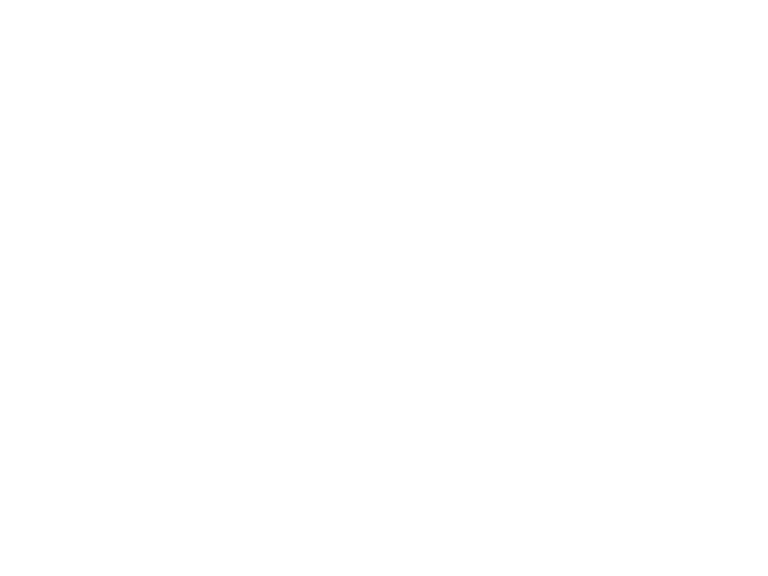

In [13]:
""" random lines generation visualized """
randomLines = generateRandomLines(5, (-10,1), (5,5))
scene = Scene([PointsCollection([])], 
              [LinesCollection(randomLines)]) 
plot3 = Plot([scene])
plot3.draw()

In [14]:
""" sweeping algorithm checking if any two lines intersect """
%matplotlib notebook
from sortedcontainers import SortedSet

def get_neighs(T, ind):
    neighs = []
    if ind > 0:
        neighs.append(T[ind-1])
    if ind < len(T)-1:
        neighs.append(T[ind+1])
    return neighs
def find_any_cut(lines):
    tmpPts = list(map(lambda line: line_factory(line), lines))
    points = list(map(lambda pt: pt[0], tmpPts))+list(map(lambda pt: pt[1], tmpPts))
    T = SortedSet([]) # container of all active lines (leading points)
    Q = SortedSet(points, key=lambda p: p.coord) #  event structure, contains all line points and intersections
    while(len(Q)>0):
        pt = Q.pop(0)
        global X
        X = pt.coord[0]
        interPt = None
        if pt.isLeft:
            T.add(pt)
            neighs = get_neighs(T, T.index(pt)) # check intersections w neighbors
            for neigh in neighs:
                interPt = intersect(pt, neigh)
        else:
            neighs = get_neighs(T, T.index(pt.other))
            if len(neighs)==2:
                interPt = intersect(neighs[0], neighs[1])
            T.remove(pt.other)
        if interPt is not None and interPt.coord[0]>pt.coord[0]:
            return interPt
    return None
print(find_any_cut(myLines))
        

None


(7.697587287926207, 8.480448146727486)


<IPython.core.display.Javascript object>


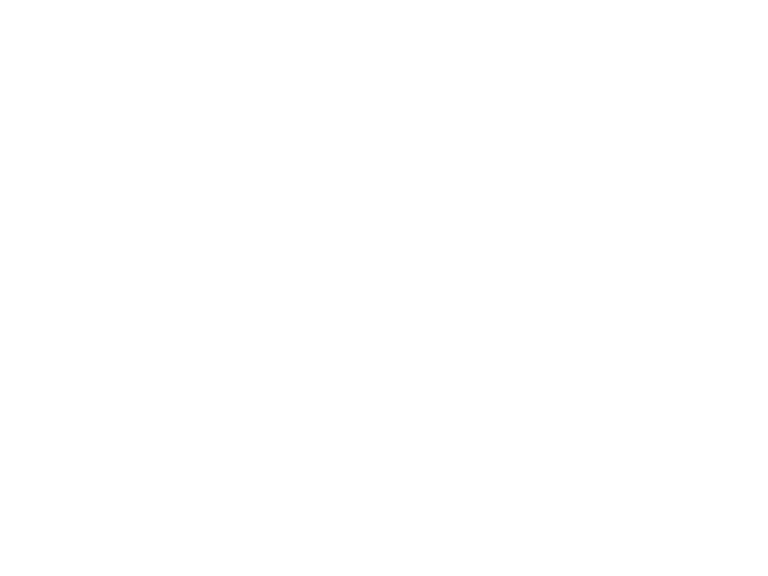

In [15]:
""" step-by-step visualization of previous algorithm """
%matplotlib notebook
from sortedcontainers import SortedSet

def get_neighs(T, ind):
    neighs = []
    if ind > 0:
        neighs.append(T[ind-1])
    if ind < len(T)-1:
        neighs.append(T[ind+1])
    return neighs
scenes = []
def find_any_cut(lines):
    tmpPts = list(map(lambda line: line_factory(line), lines))
    points = list(map(lambda pt: pt[0], tmpPts))+list(map(lambda pt: pt[1], tmpPts))
    T = SortedSet([]) # , key=lambda p: p.key
    Q = SortedSet(points, key=lambda p: p.coord) #  event structure, contains all line points and intersections
    minY= min(points, key=lambda p: p.coord[1]).coord[1]
    maxY= max(points, key=lambda p: p.coord[1]).coord[1]
    scenes.append(Scene(lines=
    [LinesCollection(pointsToLineCoord(points), color='lightgrey')],
                        points= [PointsCollection([])]
    ))
    while(len(Q)>0):
        pt = Q.pop(0)
        global X
        X = pt.coord[0]
        broom = [(pt.coord[0],minY), (pt.coord[0],maxY)]
        scenes.append(Scene(
                    [],
                    [LinesCollection(pointsToLineCoord(points), color='lightgrey'), 
                        LinesCollection([broom], color='orange'),
                        LinesCollection(list(map(lambda p: p.as_line(), T)), color='limegreen')]
                    ))
        interPt = None
        if pt.isLeft:
            T.add(pt)
            scenes.append(Scene(
                    [],
                    [LinesCollection(pointsToLineCoord(points), color='lightgrey'), 
                        LinesCollection([broom], color='orange'),
                        LinesCollection(list(map(lambda p: p.as_line(), T)), color='limegreen')]
                    ))
            neighs = get_neighs(T, T.index(pt)) # check intersections w neighbors
            for neigh in neighs:
                interPt = intersect(pt, neigh)
        else:
            neighs = get_neighs(T, T.index(pt.other))
            if len(neighs)==2:
                interPt = intersect(neighs[0], neighs[1])
            T.remove(pt.other)
        if interPt is not None and interPt.coord[0]>pt.coord[0]:
            scenes.append(Scene(
                    [PointsCollection([interPt.coord])],
                    [LinesCollection(pointsToLineCoord(points), color='lightgrey'), 
                        LinesCollection([broom], color='orange'),
                        LinesCollection(list(map(lambda p: p.as_line(), T)), color='limegreen')]
                    ))
            return interPt
        
# test
pts = generateRandomLines(5, (0,0), (10,10))
ans = find_any_cut(pts)
print(ans)

plot6 = Plot(scenes)
plot6.draw()

SortedSet([], key=<function sweeping.<locals>.<lambda> at 0x0000015E1C8E0158>)


<IPython.core.display.Javascript object>


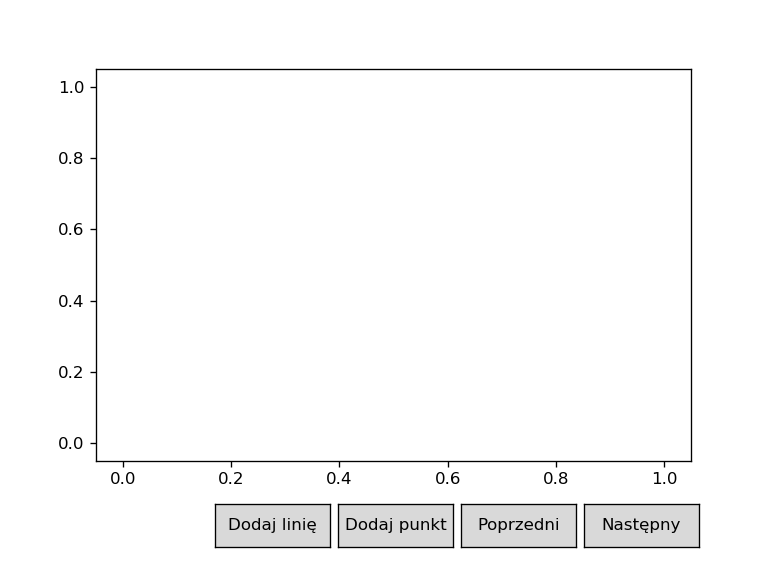

In [18]:
""" sweeping algorithm implementation using entire points as keys in T. Returns all intersections /
between any 2 segments """
%matplotlib notebook
from functools import cmp_to_key
from sortedcontainers import SortedSet

def get_neighs(T, ind):
    neighs = []
    if ind > 0:
        neighs.append(T[ind-1])
    if ind < len(T)-1:
        neighs.append(T[ind+1])
    return neighs
    
def sweeping(lines, eps=0.001):  # lines - list of pairs of tuples (x1, y1) (x2, y2) where x1 < x2
    tmpPts = list(map(lambda line: line_factory(line), lines))
    points = list(map(lambda pt: pt[0], tmpPts))+list(map(lambda pt: pt[1], tmpPts))
    T = SortedSet([]) # contains all active line segments ordered by y
    Q = SortedSet(points, key=lambda p: p.coord) # event structure, contains all event points
    intersections = SortedSet([], key=lambda p: p.coord)
    while(len(Q)>0):
        currPt = Q.pop(0)
        global X
        X = currPt.coord[0]-eps  # to dynamically calculate key
        interPt = None
        if(currPt.isLeft):  # beginning of segment
            T.add(currPt)
            neighs = get_neighs(T, T.index(currPt)) # check intersections w neighbors
            for neigh in neighs:
                interPt = intersect(currPt, neigh)
            
        elif(not currPt.isLeft and not currPt.isInter):  # end of segment
            neighs = get_neighs(T, T.index(currPt.other))
            if len(neighs)==2:
                interPt = intersect(neighs[0], neighs[1])
            T.remove(currPt.other)
            
        else:  # intersection
            line1, line2 = currPt.collidingLine1, currPt.collidingLine2
            neighs = [get_neighs(T, T.index(line1)) , get_neighs(T, T.index(line2))]
            for neigh in neighs:
                if len(neigh) == 2:
                    interPt = intersect(neigh[0], neigh[1])
            T.remove(line1)
            T.remove(line2)
            X = currPt.coord[0]+eps
            T.add(line1)
            T.add(line2)
        if interPt is not None and interPt.coord[0]>currPt.coord[0] and interPt not in intersections:
            Q.add(interPt)
            intersections.add(interPt)
    return intersections

# test
ans = sweeping(myLines)
print(ans)
scene = Scene([PointsCollection( list(map(lambda p: p.coord ,ans)) ) ],
             [LinesCollection(myLines)]
             )

plot4 = Plot([scene])
plot4.draw()


In [17]:
""" step by step visualization of sweeping algorithm """
%matplotlib notebook
from functools import cmp_to_key
from sortedcontainers import SortedSet

def get_neighs(T, ind):
    neighs = []
    if ind > 0:
        neighs.append(T[ind-1])
    if ind < len(T)-1:
        neighs.append(T[ind+1])
    return neighs
scenes = []
def sweeping(lines, eps=0.001):  # lines - list of pairs of tuples (x1, y1) (x2, y2) where x1 < x2
    tmpPts = list(map(lambda line: line_factory(line), lines))
    points = list(map(lambda pt: pt[0], tmpPts))+list(map(lambda pt: pt[1], tmpPts))
    T = SortedSet([]) # contains all active line segments ordered by y
    Q = SortedSet(points, key=lambda p: p.coord) # event structure, contains all event points
    intersections = SortedSet([], key=lambda p: p.coord)
    scenes.append(Scene(lines=
    [LinesCollection(pointsToLineCoord(points), color='lightgrey')],
                        points= [PointsCollection([])]
    ))
    minY= min(points, key=lambda p: p.coord[1]).coord[1]
    maxY= max(points, key=lambda p: p.coord[1]).coord[1]
    while(len(Q)>0):
        currPt = Q.pop(0)
        global X
        X = currPt.coord[0]-eps  # to dynamically calculate key
        broom = [(currPt.coord[0],minY), (currPt.coord[0],maxY)]
        scenes.append(Scene(
                    [PointsCollection(list(map(lambda p: p.coord ,intersections))) ],
                    [LinesCollection(pointsToLineCoord(points), color='lightgrey'), 
                        LinesCollection([broom], color='orange'),
                        LinesCollection(list(map(lambda p: p.as_line(), T)), color='limegreen')]
                    ))
        interPt = None
        if(currPt.isLeft):  # beginning of segment
            T.add(currPt)
            scenes.append(Scene(
                    [PointsCollection(list(map(lambda p: p.coord ,intersections))) ],
                    [LinesCollection(pointsToLineCoord(points), color='lightgrey'), 
                        LinesCollection([broom], color='orange'),
                        LinesCollection(list(map(lambda p: p.as_line(), T)), color='limegreen')]
                    ))
            neighs = get_neighs(T, T.index(currPt)) # check intersections w neighbors
            for neigh in neighs:
                interPt = intersect(currPt, neigh)
            
        elif(not currPt.isLeft and not currPt.isInter):  # end of segment
            neighs = get_neighs(T, T.index(currPt.other))
            if len(neighs)==2:
                interPt = intersect(neighs[0], neighs[1])
            T.remove(currPt.other)
            
        else:  # intersection
            line1, line2 = currPt.collidingLine1, currPt.collidingLine2
            neighs = [get_neighs(T, T.index(line1)) , get_neighs(T, T.index(line2))]
            for neigh in neighs:
                if len(neigh) == 2:
                    interPt = intersect(neigh[0], neigh[1])
            T.remove(line1)
            T.remove(line2)
            X = currPt.coord[0]+eps
            T.add(line1)
            T.add(line2)
        if interPt is not None and interPt.coord[0]>currPt.coord[0]:
            if interPt in intersections:
                continue
            Q.add(interPt)
            intersections.add(interPt)
            scenes.append(Scene(
            [PointsCollection(list(map(lambda p: p.coord ,intersections))),
                PointsCollection([interPt.coord], color='red')],
            [LinesCollection(pointsToLineCoord(points), color='lightgrey'), 
                LinesCollection([broom], color='orange'),
                LinesCollection(list(map(lambda p: p.as_line(), T)), color='limegreen')]
            ))
    return intersections

# test
pts = generateRandomLines(5, (0,0), (10,10))
ans = sweeping(myLines)
print(ans)

plot4 = Plot(scenes)
plot4.draw()

ValueError: min() arg is an empty sequence

In [ ]:
"""
Implementation of Red-Black tree.
"""


class RBNode:
    def __init__(self, val, is_red, parent=None, left=None, right=None):
        self.val = val
        self.parent = parent
        self.left = left
        self.right = right
        self.color = is_red


class RBTree:
    def __init__(self):
        self.root = None

    def left_rotate(self, node):
        # set the node as the left child node of the current node's right node
        right_node = node.right
        if right_node is None:
            return
        else:
            # right node's left node become the right node of current node
            node.right = right_node.left
            if right_node.left is not None:
                right_node.left.parent = node
            right_node.parent = node.parent
            # check the parent case
            if node.parent is None:
                self.root = right_node
            elif node is node.parent.left:
                node.parent.left = right_node
            else:
                node.parent.right = right_node
            right_node.left = node
            node.parent = right_node

    def right_rotate(self, node):
        # set the node as the right child node of the current node's left node
        left_node = node.left
        if left_node is None:
            return
        else:
            # left node's right  node become the left node of current node
            node.left = left_node.right
            if left_node.right is not None:
                left_node.right.parent = node
            left_node.parent = node.parent
            # check the parent case
            if node.parent is None:
                self.root = left_node
            elif node is node.parent.left:
                node.parent.left = left_node
            else:
                node.parent.right = left_node
            left_node.right = node
            node.parent = left_node

    def insert(self, node):
        # the inserted node's color is default is red
        root = self.root
        insert_node_parent = None
        # find the position of inserted node
        while root is not None:
            insert_node_parent = root
            if insert_node_parent.val < node.val:
                root = root.right
            else:
                root = root.left
        # set the n ode's parent node
        node.parent = insert_node_parent
        if insert_node_parent is None:
            # case 1  inserted tree is null
            self.root = node
        elif insert_node_parent.val > node.val:
            # case 2 not null and find left or right
            insert_node_parent.left = node
        else:
            insert_node_parent.right = node
        node.left = None
        node.right = None
        node.color = 1
        # fix the tree to 
        self.fix_insert(node)

    def fix_insert(self, node):
        # case 1 the parent is null, then set the inserted node as root and color = 0
        if node.parent is None:
            node.color = 0
            self.root = node
            return
            # case 2 the parent color is black, do nothing
        # case 3 the parent color is red
        while node.parent and node.parent.color == 1:
            if node.parent is node.parent.parent.left:
                uncle_node = node.parent.parent.right
                if uncle_node and uncle_node.color == 1:
                    # case 3.1 the uncle node is red
                    # then set parent and uncle color is black and grandparent is red
                    # then node => node.parent
                    node.parent.color = 0
                    node.parent.parent.right.color = 0
                    node.parent.parent.color = 1
                    node = node.parent.parent
                    continue
                elif node is node.parent.right:
                    # case 3.2 the uncle node is black or null, and the node is right of parent
                    # then set his parent node is current node
                    # left rotate the node and continue the next
                    node = node.parent
                    self.left_rotate(node)
                # case 3.3 the uncle node is black and parent node is left
                # then parent node set black and grandparent set red
                node.parent.color = 0
                node.parent.parent.color = 1
                self.right_rotate(node.parent.parent)
            else:
                uncle_node = node.parent.parent.left
                if uncle_node and uncle_node.color == 1:
                    # case 3.1 the uncle node is red
                    # then set parent and uncle color is black and grandparent is red
                    # then node => node.parent
                    node.parent.color = 0
                    node.parent.parent.left.color = 0
                    node.parent.parent.color = 1
                    node = node.parent.parent
                    continue
                elif node is node.parent.left:
                    # case 3.2 the uncle node is black or null, and the node is right of parent
                    # then set his parent node is current node
                    # left rotate the node and continue the next
                    node = node.parent
                    self.right_rotate(node)
                # case 3.3 the uncle node is black and parent node is left
                # then parent node set black and grandparent set red
                node.parent.color = 0
                node.parent.parent.color = 1
                self.left_rotate(node.parent.parent)
        self.root.color = 0

    def transplant(self, node_u, node_v):
        """
        replace u with v
        :param node_u: replaced node
        :param node_v: 
        :return: None
        """
        if node_u.parent is None:
            self.root = node_v
        elif node_u is node_u.parent.left:
            node_u.parent.left = node_v
        elif node_u is node_u.parent.right:
            node_u.parent.right = node_v
        # check is node_v is None 
        if node_v:
            node_v.parent = node_u.parent

    def maximum(self, node):
        """
        find the max node when node regard as a root node   
        :param node: 
        :return: max node 
        """
        temp_node = node
        while temp_node.right is not None:
            temp_node = temp_node.right
        return temp_node

    def minimum(self, node):
        """
        find the minimum node when node regard as a root node   
        :param node:
        :return: minimum node 
        """
        temp_node = node
        while temp_node.left:
            temp_node = temp_node.left
        return temp_node

    def delete(self, node):
        # find the node position
        node_color = node.color
        if node.left is None:
            temp_node = node.right
            self.transplant(node, node.right)
        elif node.right is None:
            temp_node = node.left
            self.transplant(node, node.left)
        else:
            # both child exits ,and find minimum child of right child
            node_min = self.minimum(node.right)
            node_color = node_min.color
            temp_node = node_min.right
            ## 
            if node_min.parent != node:
                self.transplant(node_min, node_min.right)
                node_min.right = node.right
                node_min.right.parent = node_min
            self.transplant(node, node_min)
            node_min.left = node.left
            node_min.left.parent = node_min
            node_min.color = node.color
        # when node is black, then need to fix it with 4 cases
        if node_color == 0:
            self.delete_fixup(temp_node)

    def delete_fixup(self, node):
        # 4 cases
        while node != self.root and node.color == 0:
            # node is not root and color is black
            if node == node.parent.left:
                # node is left node
                node_brother = node.parent.right

                # case 1: node's red, can not get black node
                # set brother is black and parent is red 
                if node_brother.color == 1:
                    node_brother.color = 0
                    node.parent.color = 1
                    self.left_rotate(node.parent)
                    node_brother = node.parent.right

                # case 2: brother node is black, and its children node is both black
                if (node_brother.left is None or node_brother.left.color == 0) and (
                                node_brother.right is None or node_brother.right.color == 0):
                    node_brother.color = 1
                    node = node.parent
                else:

                    # case 3: brother node is black , and its left child node is red and right is black
                    if node_brother.right is None or node_brother.right.color == 0:
                        node_brother.color = 1
                        node_brother.left.color = 0
                        self.right_rotate(node_brother)
                        node_brother = node.parent.right

                    # case 4: brother node is black, and right is red, and left is any color
                    node_brother.color = node.parent.color
                    node.parent.color = 0
                    node_brother.right.color = 0
                    self.left_rotate(node.parent)
                node = self.root
                break
            else:
                node_brother = node.parent.left
                if node_brother.color == 1:
                    node_brother.color = 0
                    node.parent.color = 1
                    self.left_rotate(node.parent)
                    node_brother = node.parent.right
                if (node_brother.left is None or node_brother.left.color == 0) and (
                                node_brother.right is None or node_brother.right.color == 0):
                    node_brother.color = 1
                    node = node.parent
                else:
                    if node_brother.left is None or node_brother.left.color == 0:
                        node_brother.color = 1
                        node_brother.right.color = 0
                        self.left_rotate(node_brother)
                        node_brother = node.parent.left
                    node_brother.color = node.parent.color
                    node.parent.color = 0
                    node_brother.left.color = 0
                    self.right_rotate(node.parent)
                node = self.root
                break
        node.color = 0

    def inorder(self):
        res = []
        if not self.root:
            return res
        stack = []
        root = self.root
        while root or stack:
            while root:
                stack.append(root)
                root = root.left
            root = stack.pop()
            res.append({'val': root.val, 'color': root.color})
            root = root.right
        return res

In [ ]:
""" tests """
# intersection tests
pa = Point((0, 0), True, False)
pb = Point((2, 2))
pa.add_other(pb)

pc = Point((-3, 1), True, False)
pd = Point((5, 2))
pc.add_other(pd)

print(intersect(pa, pc))

# sweeping tests
# test values
a1, a2 =line_factory((1,4), (4,3))
a3, a4 =line_factory((3,5), (6,5))
a5, a6 = line_factory((2,3), (4,4))
a7, a8 = line_factory((3.5,3.5), (4,6))
a8, a9 =  line_factory((0,0), (4,4))
a10, a11 = line_factory((0,2), (2,0))

pts = [a8, a9, a10, a11]